In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2, InterpolationMode
from torchvision import models
from tqdm import tqdm
import os
import cv2

In [2]:
class Config:
    BASE_PATH = '/kaggle/input/utkface/UTKFace'
    BATCH_SIZE = 64
    SEED = 42
    IMG_SIZE = (224,224)
    
config = Config()

In [3]:
torch.manual_seed(config.SEED)

In [4]:
def get_data(path):
    images = []
    labels = []
    extensions = ['jpg','png','jpeg','bmp']
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path,folder)):
            if len(file.split('.')) > 1 and file.split('.')[1] in extensions:
                images.append(
                    os.path.join(path,folder,file)
                )
                label = int(file.split('_')[0])
                labels.append(label)
    return images,labels

images,labels = get_data(config.BASE_PATH)
images[:5],labels[:5]

(['/kaggle/input/utkface/UTKFace/part1/10_0_0_20170110220548521.jpg',
  '/kaggle/input/utkface/UTKFace/part1/2_1_4_20161221195444552.jpg',
  '/kaggle/input/utkface/UTKFace/part1/1_1_2_20161219155356357.jpg',
  '/kaggle/input/utkface/UTKFace/part1/49_0_0_20170103182824970.jpg',
  '/kaggle/input/utkface/UTKFace/part1/1_1_0_20170109190459034.jpg'],
 [10, 2, 1, 49, 1])

In [5]:
metadata = pd.DataFrame(
    {
        'ID': images,
        'Age': labels
    }
)

bins = [0, 20, 40, 60, 1000]
labels = ['0-20','20-40','40-60','60+']
metadata['Age'] = pd.cut(metadata['Age'],bins=bins,labels=labels)
metadata

,ID,Age
0,/kaggle/input/utkface/UTKFace/part1/10_0_0_201...,0-20
1,/kaggle/input/utkface/UTKFace/part1/2_1_4_2016...,0-20
2,/kaggle/input/utkface/UTKFace/part1/1_1_2_2016...,0-20
3,/kaggle/input/utkface/UTKFace/part1/49_0_0_201...,40-60
4,/kaggle/input/utkface/UTKFace/part1/1_1_0_2017...,0-20
...,...,...
24101,/kaggle/input/utkface/UTKFace/part3/35_1_0_201...,20-40
24102,/kaggle/input/utkface/UTKFace/part3/43_0_4_201...,40-60
24103,/kaggle/input/utkface/UTKFace/part3/26_0_3_201...,20-40
24104,/kaggle/input/utkface/UTKFace/part3/26_1_3_201...,20-40


In [6]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

images = metadata['ID'].values
labels = metadata['Age'].values
encoder.fit(labels)

LabelBinarizer()

In [7]:
import pickle

with open('/kaggle/working/encoder.pkl','wb') as f:
    pickle.dump(list(encoder.classes_),f)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(images,
                                                   labels,
                                                   test_size=0.2,
                                                   random_state=config.SEED)
x_train[:5],y_train[:5]

(array(['/kaggle/input/utkface/UTKFace/part1/51_0_4_20170104210348196.jpg',
        '/kaggle/input/utkface/UTKFace/part1/37_1_0_20170103163508220.jpg',
        '/kaggle/input/utkface/UTKFace/part1/15_1_0_20170109213448729.jpg',
        '/kaggle/input/utkface/UTKFace/part2/45_0_3_20170113190535208.jpg',
        '/kaggle/input/utkface/UTKFace/part2/54_1_0_20170117171158860.jpg'],
       dtype=object),
 ['40-60', '20-40', '0-20', '40-60', '40-60']
 Categories (4, object): ['0-20' < '20-40' < '40-60' < '60+'])

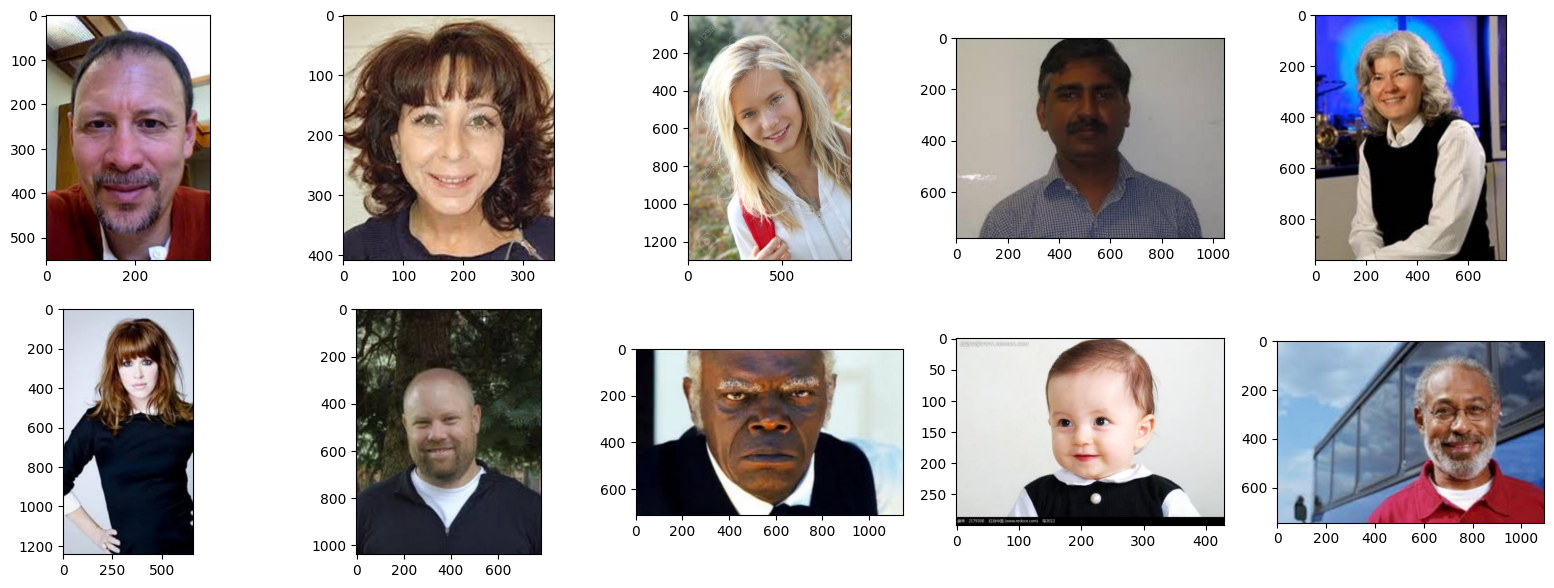

In [9]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    img=cv2.imread(x_train[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)

In [10]:
class ImageDataset(Dataset):
    def __init__(self,image_paths,labels,encoder,transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.encoder = encoder
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = PIL.Image.open(image_path).convert('RGB')
        label = torch.tensor(self.encoder.transform([label])).squeeze(0).float()
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
def get_transform(img_size):
    transform = v2.Compose([
        v2.ToImage(),
        v2.Resize(size = img_size, 
                  interpolation = InterpolationMode.BILINEAR),
        v2.ToDtype(torch.float32,scale=True),
        v2.Normalize(mean = [0.485, 0.456, 0.406], 
                     std = [0.229, 0.224, 0.225])
    ])
    return transform

In [12]:
def loading_data(img_size,image_paths,labels,encoder,batch_size,shuffle):
    transform = get_transform(img_size)
    dataset = ImageDataset(image_paths,labels,encoder,transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [13]:
train_loader = loading_data(config.IMG_SIZE, 
                            x_train, 
                            y_train, 
                            encoder, 
                            config.BATCH_SIZE,
                            shuffle=True)
val_loader = loading_data(config.IMG_SIZE, 
                            x_valid, 
                            y_valid, 
                            encoder, 
                            config.BATCH_SIZE,
                            shuffle=False)

In [14]:
for i,(x,y) in enumerate(train_loader):
    if i==1:
        break
    print(x.size(),y.size())

torch.Size([64, 3, 224, 224]) torch.Size([64, 4])


In [15]:
class AgeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = models.mobilenet_v3_large(weights='DEFAULT')
        self.model.classifier[3] = nn.Linear(1280, 4)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.opt = torch.optim.AdamW(self.model.parameters(),lr=1e-2)

    def change_lr(self,new_lr):
        for g in self.opt.param_groups:
            g['lr'] = new_lr
            
    def freeze_model(self):
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad = False
        for p in self.model.classifier.parameters():
            p.requires_grad = True
        #for layer in self.model.modules():
            #if isinstance(layer,nn.BatchNorm2d):
                #layer.eval()
            
    def unfreeze_model(self):
        self.model.train()
        for p in self.model.parameters():
            p.requires_grad = True
            
    def forward(self):
        h = self.model(self.images)
        return h

    def prepare_input(self,x,y):
        self.images = x.to(self.device)
        self.labels = y.to(self.device)

    def optimize(self,x,y,mode):
        self.prepare_input(x,y)
        
        if mode == 'transfer':
            self.freeze_model()
        elif mode == 'fine-tune':
            self.unfreeze_model()
        else:
            raise Exception('Mode must be either "transfer" or "fine-tune"')
        
        self.opt.zero_grad()
        pred = self.forward()
        loss = self.loss_fn(pred,self.labels)
        loss.backward()
        self.opt.step()
        return loss.item()

    def evaluate(self,x,y):
        self.prepare_input(x,y)
        self.model.eval()
        with torch.no_grad():
            pred = self.forward()
            loss = self.loss_fn(pred,self.labels)
        return loss.item()

    def predict(self,x):
        self.images = x.to(self.device)
        self.model.eval()
        with torch.no_grad():
            pred = self.forward()
            pred = F.softmax(pred,dim=1)
        return pred

In [16]:
class Trainer():
    def __init__(self,
                 model) -> None:
        self.model=model
        self.history={'losses':[],
                      'val_losses':[]}
        self.best_loss = float('inf')
        self.best_model = None
        self.scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=self.model.opt,
                                                                      patience=5,
                                                                      min_lr=1e-6,
                                                                      factor=0.2)

    def __trainstep(self,train_loader: DataLoader, verbose: int, mode:str):
        train_loss=0
        batches=len(train_loader)
        if verbose == 1:
            train_loader=tqdm(train_loader)
        for iter,(x,y) in enumerate(train_loader):
            loss=self.model.optimize(x,y,mode)
            if verbose==1:
                train_loader.set_postfix({'loss':loss})
            train_loss+=loss
        train_loss/=batches
        self.history['losses'].append(train_loss)
    
    def __evalstep(self, val_loader: DataLoader,verbose: int):
        val_loss=0
        batches=len(val_loader)
        if verbose == 1:
            val_loader=tqdm(val_loader)
        for x,y in val_loader:
            loss=self.model.evaluate(x,y)
            if verbose==1:
                val_loader.set_postfix({'val_loss':loss})
            val_loss+=loss
        val_loss/=batches
        self.history['val_losses'].append(val_loss)
        
    def fit(self, train_loader: DataLoader,
            val_loader: DataLoader,
            epochs: int,
            verbose: int,
            patience: int, 
            mode:str):
        assert verbose in [0,1], 'verbose must be either 0 or 1'
        try:
            for i in range(epochs):
                if verbose == 1:
                    print(f'\nEpoch: {i+1}')
                self.__trainstep(train_loader, verbose, mode)
                self.__evalstep(val_loader, verbose)
                self.scheduler.step(self.history['val_losses'][-1])
                if self.history['val_losses'][-1] - self.best_loss < 1e-6 :
                    self.best_loss=self.history['val_losses'][-1]
                    self.best_model=self.model.model.state_dict()
                    patience+=1
                else:
                    patience-=1
                    if patience == 0:
                        break
        except KeyboardInterrupt:
            print('Interrupted!')
        finally:
            self.model.model.load_state_dict(self.best_model)
            if verbose == 1:
                print('best loss:', self.best_loss)
                
    def predict(self, test_loader):
        preds = []
        for x in test_loader:
            pred = self.model.predict(x[0])
            preds.append(pred.cpu().numpy())
        return np.concatenate(preds,axis=0)

In [17]:
model = AgeDetector()
trainer = Trainer(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 160MB/s]


In [18]:
trainer.fit(train_loader,
            val_loader,
            epochs=1,
            verbose=1,
            patience=1,
            mode='transfer')


Epoch: 1


100%|██████████| 76/76 [01:39<00:00,  1.31s/it, val_loss=0.653]

best loss: 0.6887499925337339


In [19]:
trainer.model.change_lr(2e-4)

trainer.fit(train_loader,            
            val_loader,
            epochs=20,
            verbose=1,
            patience=10,
            mode='fine-tune')


Epoch: 1


100%|██████████| 76/76 [00:51<00:00,  1.48it/s, val_loss=0.394]



Epoch: 2


100%|██████████| 76/76 [00:56<00:00,  1.34it/s, val_loss=0.31]



Epoch: 3


100%|██████████| 76/76 [00:52<00:00,  1.45it/s, val_loss=0.394]



Epoch: 4


100%|██████████| 76/76 [00:52<00:00,  1.46it/s, val_loss=0.493]



Epoch: 5


100%|██████████| 76/76 [00:52<00:00,  1.46it/s, val_loss=0.52]



Epoch: 6


100%|██████████| 76/76 [00:53<00:00,  1.42it/s, val_loss=0.493]



Epoch: 7


100%|██████████| 76/76 [01:32<00:00,  1.22s/it, val_loss=0.608]



Epoch: 8


100%|██████████| 76/76 [01:00<00:00,  1.25it/s, val_loss=0.52]



Epoch: 9


100%|██████████| 76/76 [00:53<00:00,  1.42it/s, val_loss=0.472]



Epoch: 10


100%|██████████| 76/76 [00:53<00:00,  1.42it/s, val_loss=0.471]



Epoch: 11


100%|██████████| 76/76 [01:00<00:00,  1.25it/s, val_loss=0.619]



Epoch: 12


100%|██████████| 76/76 [00:56<00:00,  1.35it/s, val_loss=0.456]

best loss: 0.5192842883499045


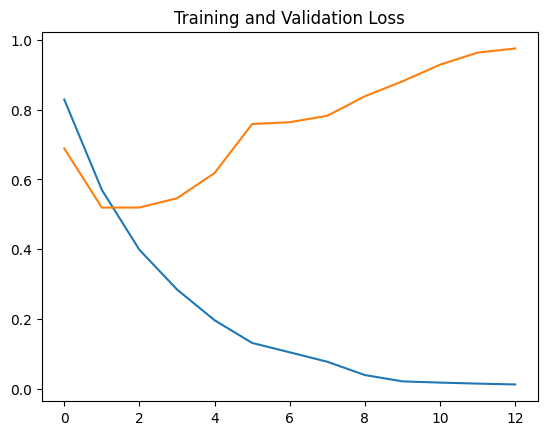

In [20]:
loss = trainer.history['losses']
val_loss = trainer.history['val_losses']
epoch = range(len(loss))
plt.plot(epoch,loss,label='Training loss')
plt.plot(epoch,val_loss,label='Validation loss')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
preds = trainer.predict(val_loader)
preds = np.round(preds)
preds.shape

(4822, 4)

              precision    recall  f1-score   support

        0-20       0.92      0.85      0.88      1027
       20-40       0.85      0.89      0.87      2433
       40-60       0.61      0.63      0.62       843
         60+       0.81      0.72      0.76       519

    accuracy                           0.82      4822
   macro avg       0.80      0.77      0.78      4822
weighted avg       0.82      0.82      0.82      4822



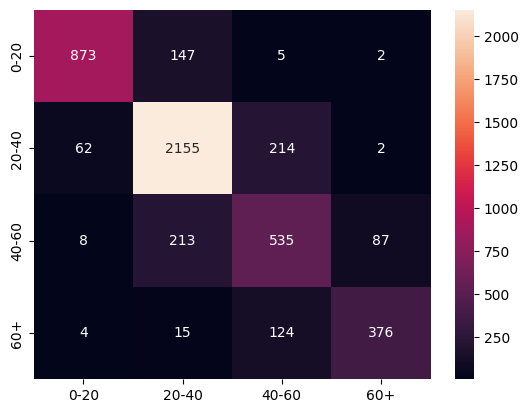

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_valid.to_numpy(), encoder.inverse_transform(preds))

print(
    classification_report(y_valid.to_numpy(),
                          encoder.inverse_transform(preds),
                          target_names=encoder.classes_)
)
sns.heatmap(cm_test,
            annot=True,
            fmt='g',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.show()

In [23]:
torch.save(
    trainer.model.model.state_dict(),'/kaggle/working/age_detector.pth'
)